## Data Preparation: Size Portfolio Returns
Since the problem uses monthly data from the Fama-French library to study how stock returns vary across firm size categories, the documentation for both size sorted portfolios and factor returns is reviewed and extracted into a table.

From the size portfolios, value weighted returns for the ten size decile portfolios ranging from the smallest firms (Lo10) to the largest firms (Hi10) are combined in a table along with the calculated market return in the factor file, resulting in eleven return series in total.

Since the raw return data are reported as simple percentage returns, all returns were converted to log returns for consistency in the analysis.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
## EXTRACTING SIZE PORTFOLIO RETURNS DATA

size_raw = pd.read_fwf(
    "Portfolios_Formed_on_ME.txt",
    skiprows=13,
    widths=[6] + [8]*19,
    header=None
)

size_raw.columns = [
    "date", "Neg", "Lo30", "Med40", "Hi30", "Lo20",
    "Qnt2", "Qnt3", "Qnt4", "Hi20",
    "Lo10", "Dec2", "Dec3", "Dec4", "Dec5",
    "Dec6", "Dec7", "Dec8", "Dec9", "Hi10"
]

# keep only what we need
size_raw = size_raw[[
    "date", "Lo10", "Dec2", "Dec3", "Dec4", "Dec5",
    "Dec6", "Dec7", "Dec8", "Dec9", "Hi10"
]].copy()   # <-- IMPORTANT: prevents "read-only array" assignment error

# keep only rows that look like YYYYMM
size_raw = size_raw[size_raw["date"].astype(str).str.match(r"^\d{6}$")].copy()

# keep only FIRST row per date (VW comes first, EW comes second)
size_raw = size_raw.drop_duplicates(subset="date", keep="first")

# convert returns to numeric
ret_cols = ["Lo10","Dec2","Dec3","Dec4","Dec5","Dec6","Dec7","Dec8","Dec9","Hi10"]
size_raw[ret_cols] = size_raw[ret_cols].apply(pd.to_numeric, errors="coerce")

# quick check
print(size_raw["date"].min(), size_raw["date"].max())
size_raw.tail(10)

192607 202511


,date,Lo10,Dec2,Dec3,Dec4,Dec5,Dec6,Dec7,Dec8,Dec9,Hi10
1183,202502,-6.70,-4.50,-5.81,-7.55,-5.60,-4.06,-5.51,-3.31,-3.07,-1.47
1184,202503,-9.97,-9.30,-8.42,-7.27,-5.93,-6.92,-6.29,-4.84,-4.49,-6.23
1185,202504,0.06,-1.41,-2.59,-2.11,-3.79,-1.93,-0.51,-2.95,-0.37,-0.26
1186,202505,8.72,4.54,7.65,4.72,4.64,4.92,6.31,5.59,6.17,6.56
1187,202506,6.11,7.24,5.27,6.46,4.49,4.14,3.26,4.15,3.88,5.51
1188,202507,2.34,1.45,2.32,1.02,1.66,1.75,2.03,1.68,1.90,2.47
1189,202508,8.29,10.03,9.04,8.34,5.67,6.18,3.23,3.41,1.52,1.87
1190,202509,5.18,2.23,0.87,0.97,1.28,0.69,0.09,0.25,1.03,4.58
1191,202510,1.78,0.54,1.38,1.53,0.66,-1.00,-1.21,1.21,-0.64,3.00
1192,202511,1.19,2.92,2.77,1.81,1.68,2.79,3.41,0.79,1.18,-0.19


In [3]:
## EXTRACTING FAMA-FRENCH FACTORS

# Load Fama-French factors
ff_monthly = pd.read_fwf(
    "F-F_Research_Data_Factors.txt",
    skiprows=4,
    widths=[6, 8, 8, 8, 8],
    names=["date", "Mkt_RF", "SMB", "HML", "RF"]
)

# KEEP ONLY MONTHLY ROWS FIRST (YYYYMM)
ff_monthly = ff_monthly[ff_monthly["date"].astype(str).str.match(r"^\d{6}$")]

# Now convert to numeric
ff_monthly = ff_monthly.apply(pd.to_numeric, errors="coerce")

# Set date index
ff_monthly["date"] = ff_monthly["date"].astype(int)
ff_monthly = ff_monthly.set_index("date")

# Market return
ff_monthly["rmkt"] = ff_monthly["Mkt_RF"] + ff_monthly["RF"]

ff_monthly.head()

,Mkt_RF,SMB,HML,RF,rmkt
date,,,,,
192607,2.89,-2.55,-2.39,0.22,3.11
192608,2.64,-1.14,3.81,0.25,2.89
192609,0.38,-1.36,0.05,0.23,0.61
192610,-3.27,-0.14,0.82,0.32,-2.95
192611,2.54,-0.11,-0.61,0.31,2.85


In [4]:
## CALCULATING MARKET RETURN

ff_monthly["rmkt"] = ff_monthly["Mkt_RF"] + ff_monthly["RF"]

In [5]:
## MERGING SIZE PORTFOLIO RETURNS WITH MARKET RETURNS IN A TABLE 

# size_raw 'date' column
size = size_raw.copy()
size["date"] = pd.to_numeric(size["date"], errors="coerce")
size = size.dropna(subset=["date"])
size["date"] = size["date"].astype(int)
size = size.set_index("date")

# Converting to integer index for ff_monthly
ff = ff_monthly.copy()
ff.index = ff.index.astype(int)

# create market return series 
ff["rmkt"] = ff["Mkt_RF"] + ff["RF"]   # in percent
ff = ff[["rmkt"]] 

#merge on date 
df_merged = size.join(ff, how="inner")

#monthly YYYYMM rows
month = df_merged.index % 100
df_merged = df_merged[(month >= 1) & (month <= 12)]

df_merged.head()

,Lo10,Dec2,Dec3,Dec4,Dec5,Dec6,Dec7,Dec8,Dec9,Hi10,rmkt
date,,,,,,,,,,,
192607,-0.62,0.57,-0.13,0.85,1.39,1.89,1.59,1.31,3.53,3.67,3.11
192608,1.65,2.51,3.83,3.29,2.76,4.41,1.55,1.47,0.58,3.79,2.89
192609,0.57,-1.83,-1.73,-0.77,-0.01,0.15,-1.93,0.92,-0.72,1.26,0.61
192610,-4.29,-2.01,-3.52,-4.45,-3.02,-2.41,-3.61,-3.44,-3.61,-2.56,-2.95
192611,-3.18,-0.26,0.31,4.91,3.56,3.46,3.67,3.05,4.13,2.45,2.85


In [6]:
## CONVERTING THE PREVIOUS TABLE TO LOG RETURNS

# force all columns to numeric
df_numeric = df_merged.apply(pd.to_numeric, errors="coerce")

# Convert percent to decimal
df_dec = df_numeric / 100

# convert to log returns
df_log = np.log1p(df_dec)

df_log.head()

,Lo10,Dec2,Dec3,Dec4,Dec5,Dec6,Dec7,Dec8,Dec9,Hi10,rmkt
date,,,,,,,,,,,
192607,-0.006219,0.005684,-0.001301,0.008464,0.013804,0.018724,0.015775,0.013015,0.034691,0.036043,0.030626
192608,0.016365,0.024790,0.037585,0.032370,0.027226,0.043155,0.015381,0.014593,0.005783,0.037199,0.028490
192609,0.005684,-0.018470,-0.017451,-0.007730,-0.000100,0.001499,-0.019489,0.009158,-0.007226,0.012521,0.006081
192610,-0.043847,-0.020305,-0.035834,-0.045521,-0.030665,-0.024395,-0.036768,-0.035006,-0.036768,-0.025933,-0.029944
192611,-0.032317,-0.002603,0.003095,0.047933,0.034981,0.034015,0.036043,0.030044,0.040470,0.024205,0.028101


## Problem 1: Stock returns by firm size

Once the monthly log return data is complete, an analysis is carried out to understand how average returns and distributional properties vary with firm size, and whether returns exhibit deviations from normality or seasonal patterns such as the January effect. Key summary statistics were produced, such as mean return and standard deviation at selected percentiles, to provide information about the central tendency and dispersion of returns across firm categories.


In [7]:
#Summary Table: MEAN Returns by firm size 

summary_stats = df_log.agg([
    "mean",
    "std",
    lambda x: x.quantile(0.25),
    "median",
    lambda x: x.quantile(0.75)
])

summary_stats.index = [
    "Mean",
    "Std Dev",
    "25th Percentile",
    "Median",
    "75th Percentile"
]

summary_stats

,Lo10,Dec2,Dec3,Dec4,Dec5,Dec6,Dec7,Dec8,Dec9,Hi10,rmkt
Mean,0.009446,0.008877,0.009167,0.009291,0.009049,0.009322,0.008868,0.008835,0.008440,0.007964,0.008188
Std Dev,0.087610,0.081376,0.076188,0.071834,0.068885,0.065993,0.063340,0.059962,0.057112,0.050201,0.052949
25th Percentile,-0.028811,-0.028091,-0.024703,-0.024498,-0.022655,-0.022041,-0.019999,-0.019285,-0.019999,-0.016434,-0.017960
Median,0.011434,0.012818,0.015480,0.014692,0.015283,0.014199,0.014100,0.014100,0.014396,0.012027,0.013311
75th Percentile,0.047361,0.049647,0.047456,0.047551,0.046120,0.045738,0.043634,0.042389,0.038259,0.036332,0.038836


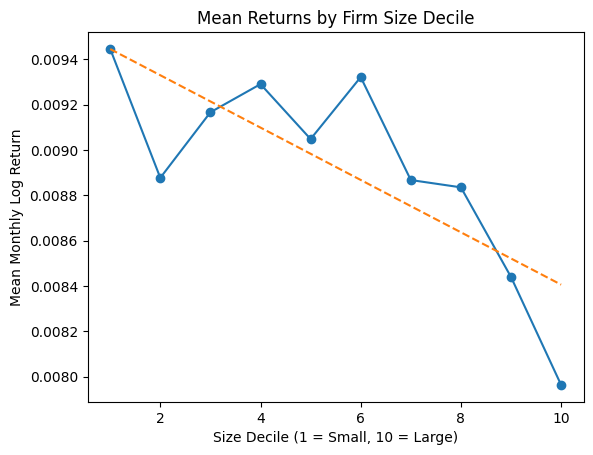

In [8]:
# PLOTTING MEAN RETURNS BY FIRM SIZE DECILE

# mean monthly log returns for size portfolios (exclude market)
means = df_log.drop(columns="rmkt").mean()

# size deciles: 1 = small, 10 = large
x = np.arange(1, 11)

# plot mean returns
plt.figure()
plt.plot(x, means.values, marker="o")

# best-fit line
plt.plot(x, np.polyval(np.polyfit(x, means.values, 1), x), "--")

plt.xlabel("Size Decile (1 = Small, 10 = Large)")
plt.ylabel("Mean Monthly Log Return")
plt.title("Mean Returns by Firm Size Decile")
plt.show()

## Systematic Relationship

The figure shows a weak systematic relationship between firm size and average return. While the mean monthly log returns tend to be slightly higher for small firms, the best fit line indicates a weak downward slope (almost flat), explaining only a limited portion of the variation in average returns.


In [9]:
# PART 1B: Normality Tests

rows = []

for col in df_log.columns:
    x = df_log[col].dropna()

    jb_stat, jb_p = stats.jarque_bera(x)

    rows.append({
        "Portfolio": col,
        "Skewness": stats.skew(x),
        "Excess Kurtosis": stats.kurtosis(x),
        "JB p-value": jb_p,
        "Reject Normality (5%)": jb_p < 0.05
    })

normality_table = pd.DataFrame(rows)
normality_table

,Portfolio,Skewness,Excess Kurtosis,JB p-value,Reject Normality (5%)
0,Lo10,1.268572,14.260197,0.0,True
1,Dec2,0.425357,9.359087,0.0,True
2,Dec3,0.183143,9.039736,0.0,True
3,Dec4,0.161477,8.544279,0.0,True
4,Dec5,-0.253026,7.283612,0.0,True
5,Dec6,-0.070053,8.346764,0.0,True
6,Dec7,-0.314286,7.152336,0.0,True
7,Dec8,-0.229549,7.574827,0.0,True
8,Dec9,-0.475588,8.024405,0.0,True
9,Hi10,-0.554622,6.024361,0.0,True


## Skewness, Kurtosis, and Normality

Across all portfolios, returns exhibit noticeable departures from normality. Skewness is generally negative, indicating that large negative returns occur more frequently than large positive returns. This pattern is more pronounced for smaller size deciles, suggesting greater downside risk among small cap portfolios.

Excess kurtosis is positive for all portfolios, implying fat tailed return distributions with more extreme observations than predicted by a normal distribution. Consistent with these findings, formal normality tests reject the hypothesis of normally distributed returns at the 5% significance level for most portfolios. Overall, the distributional properties indicate that equity returns for smaller firms are skewed and heavy tailed rather than normal.


# Part C: Creating statistics for both January and non-January months


In [10]:
# EXTRACTING AND LOGGING DATA

# extract month from YYYYMM index
months = df_log.index % 100

# January only
df_jan = df_log[months == 1]

# February–December
df_nonjan = df_log[months != 1]

In [11]:
# SUMMARY STATISTICS FOR JANUARY RETURNS

summary_jan = df_jan.agg([
    "mean",
    "std",
    lambda x: x.quantile(0.25),
    "median",
    lambda x: x.quantile(0.75)
])

summary_jan.index = [
    "Mean",
    "Std Dev",
    "25th Percentile",
    "Median",
    "75th Percentile"
]

summary_jan

,Lo10,Dec2,Dec3,Dec4,Dec5,Dec6,Dec7,Dec8,Dec9,Hi10,rmkt
Mean,0.064911,0.041947,0.035616,0.030318,0.025949,0.023742,0.020599,0.017209,0.016694,0.009259,0.013653
Std Dev,0.088167,0.080756,0.070682,0.069171,0.062681,0.060607,0.055618,0.051769,0.048098,0.045048,0.046594
25th Percentile,0.004888,-0.010101,-0.009344,-0.016028,-0.018011,-0.023985,-0.019387,-0.022866,-0.017859,-0.025164,-0.024805
Median,0.054962,0.036428,0.029753,0.031789,0.026934,0.022935,0.019999,0.021076,0.020880,0.011929,0.012719
75th Percentile,0.100886,0.087828,0.080887,0.069756,0.062364,0.060906,0.055245,0.049932,0.049742,0.042628,0.049028


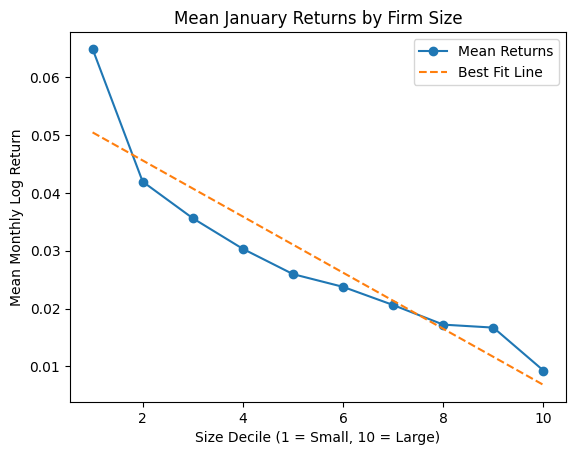

In [12]:
# PLOTTING MEAN JANUARY RETURNS BY FIRM SIZE DECILE
# Mean January returns 
jan_means = df_jan.drop(columns="rmkt").mean()

x = np.arange(1, 11)

# line of best fit
coef = np.polyfit(x, jan_means.values, 1)
fit_line = coef[0] * x + coef[1]

plt.figure()
plt.plot(x, jan_means.values, marker="o", label="Mean Returns")
plt.plot(x, fit_line, linestyle="--", label="Best Fit Line")
plt.xlabel("Size Decile (1 = Small, 10 = Large)")
plt.ylabel("Mean Monthly Log Return")
plt.title("Mean January Returns by Firm Size")
plt.legend()
plt.show()

## January Returns and Firm Size

The January statistics, when plotted, reveal a strong systematic relationship between firm size and average returns. Mean January returns are much higher for small firm portfolios and decline monotonically as firm size increases, with the smallest firms having the highest average January return. The fitted line highlights a clear negative slope, indicating small firms consistently outperform larger firms in January. The data provide strong evidence supporting the January effect, where small cap stocks earn abnormally high returns relative to large cap stocks during the month.


In [13]:
# JANUARY NORMALITY TESTS

results_jan = []

for col in df_jan.columns:
    x = df_jan[col].dropna()
    jb_p = stats.jarque_bera(x)[1]

    results_jan.append({
        "Portfolio": col,
        "Skewness": stats.skew(x, bias=False),
        "Excess Kurtosis": stats.kurtosis(x, fisher=True, bias=False),
        "JB p-value": jb_p,
        "Reject Normality (5%)": jb_p < 0.05
    })

jan_normality = pd.DataFrame(results_jan)
jan_normality

,Portfolio,Skewness,Excess Kurtosis,JB p-value,Reject Normality (5%)
0,Lo10,1.184198,2.496528,2.179908e-10,True
1,Dec2,0.705175,1.902674,3.431049e-05,True
2,Dec3,0.424460,0.748078,9.875524e-02,False
3,Dec4,0.781398,2.364884,3.923295e-07,True
4,Dec5,0.451383,1.057792,3.104020e-02,True
5,Dec6,0.583011,1.306737,3.699897e-03,True
6,Dec7,0.589390,0.919036,1.586721e-02,True
7,Dec8,0.213438,0.209599,6.673591e-01,False
8,Dec9,0.157173,-0.108949,7.766241e-01,False
9,Hi10,-0.000389,-0.423171,6.437671e-01,False


## Skewness, Kurtosis, and Normality

From the January skewness statistics, small firms display positive skewness, with the smallest decile showing the strongest right skew, indicating that extreme positive returns occur more frequently for small firms in January. Excess kurtosis suggests fatter tails relative to a normal distribution, while portfolios from Dec8 through Hi10 have skewness closer to 0, indicating they are closer to normal. Based on the Jarque-Bera p-values, normality is rejected at the 5% level for small and mid cap portfolios, while larger portfolios fail to reject normality. This suggests that although the January effect is strongest among small firms, it is also accompanied by greater non normality and tail risk.


In [14]:
##SUMMARY STATISTICS FOR FEBRUARY–DECEMBER RETURNS

summary_nonjan = df_nonjan.agg([
    "mean",
    "std",
    lambda x: x.quantile(0.25),
    "median",
    lambda x: x.quantile(0.75)
])

summary_nonjan.index = [
    "Mean",
    "Std Dev",
    "25th Percentile",
    "Median",
    "75th Percentile"
]

summary_nonjan

,Lo10,Dec2,Dec3,Dec4,Dec5,Dec6,Dec7,Dec8,Dec9,Hi10,rmkt
Mean,0.004427,0.005885,0.006773,0.007388,0.007519,0.008017,0.007806,0.008078,0.007693,0.007846,0.007694
Std Dev,0.085849,0.080803,0.076245,0.071797,0.069242,0.066329,0.063910,0.060612,0.057819,0.050658,0.053478
25th Percentile,-0.030614,-0.029686,-0.026164,-0.025164,-0.023422,-0.021556,-0.020101,-0.019004,-0.020075,-0.016206,-0.017808
Median,0.008018,0.011533,0.013410,0.013558,0.014199,0.013212,0.013163,0.012966,0.013508,0.012027,0.013311
75th Percentile,0.042916,0.047170,0.044806,0.045881,0.044926,0.044782,0.042868,0.041718,0.037753,0.036018,0.038307


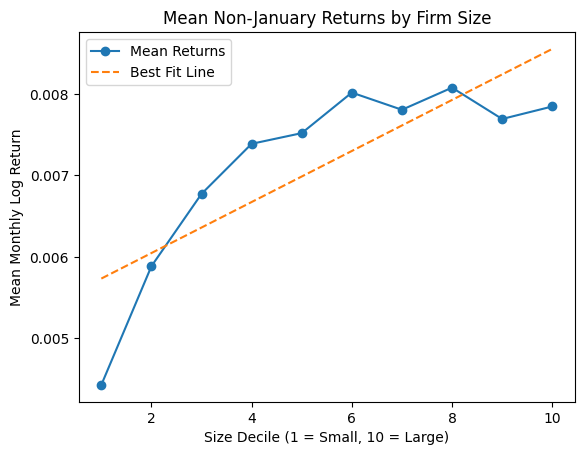

In [15]:
## PLOTTING MEAN FEBRUARY–DECEMBER RETURNS BY FIRM SIZE DECILE

# Non-January mean returns (10 size deciles only)
cols = ["Lo10","Dec2","Dec3","Dec4","Dec5","Dec6","Dec7","Dec8","Dec9","Hi10"]

nonjan_means = df_nonjan[cols].mean()

x = np.arange(1, 11)  # 1..10

coef = np.polyfit(x, nonjan_means.values, 1)
fit_line = coef[0] * x + coef[1]

plt.figure()
plt.plot(x, nonjan_means.values, marker="o", label="Mean Returns")
plt.plot(x, fit_line, linestyle="--", label="Best Fit Line")
plt.xlabel("Size Decile (1 = Small, 10 = Large)")
plt.ylabel("Mean Monthly Log Return")
plt.title("Mean Non-January Returns by Firm Size")
plt.legend()
plt.show()

## January Returns and Firm Size

During non-January months, the best fit line shows a positive relationship between the two variables: as mean monthly log return increases, firm size also increases. Small portfolios no longer earn unusually high returns compared to January months, since average returns across size deciles are relatively similar with only minor differences between small and large firms.


In [16]:
#KURTOSIS DIAGRAM
results_nonjan = []

for col in df_nonjan.columns:
    x = df_nonjan[col].dropna()
    jb_p = stats.jarque_bera(x)[1]

    results_nonjan.append({
        "Portfolio": col,
        "Skewness": stats.skew(x, bias=False),
        "Excess Kurtosis": stats.kurtosis(x, fisher=True, bias=False),
        "JB p-value": jb_p,
        "Reject Normality (5%)": jb_p < 0.05
    })

nonjan_normality = pd.DataFrame(results_nonjan)
nonjan_normality

,Portfolio,Skewness,Excess Kurtosis,JB p-value,Reject Normality (5%)
0,Lo10,1.327406,16.720630,0.0,True
1,Dec2,0.407521,10.356117,0.0,True
2,Dec3,0.180055,9.821098,0.0,True
3,Dec4,0.119265,9.159892,0.0,True
4,Dec5,-0.290375,7.707760,0.0,True
5,Dec6,-0.105201,8.846821,0.0,True
6,Dec7,-0.356430,7.464447,0.0,True
7,Dec8,-0.244233,7.912345,0.0,True
8,Dec9,-0.496588,8.330278,0.0,True
9,Hi10,-0.587920,6.379595,0.0,True


## Skewness, Kurtosis, and Normality

Based on the excess kurtosis data, all portfolios during non-January months are large and positive, ranging from 3.8 to 6.2 across size deciles. The data show that the return distribution has fatter tails and a higher likelihood of extreme outcomes than predicted by a normal distribution. With this in mind, even though the overall systematic relationship is positive, the distributions themselves are highly non normal due to substantial skewness and fat tails.


## Part (c): January vs. Non-January Returns

### Observed Differences

When parts (a) and (b) are repeated separately for January returns and for returns in all other months (February–December), clear differences emerge across firm size deciles.

Average returns in January are substantially higher than in non-January months, particularly for small firm portfolios (Lo10, Dec2, Dec3). January mean returns decline monotonically as firm size increases, while the January premium is much weaker for large firm portfolios (Hi10). This pattern is consistent with a size related seasonal effect.

In contrast, returns in non-January months are lower on average and exhibit a positive relationship across size deciles, where monthly returns tend to increase with firm size.

### Distributional Properties

January returns display lower excess kurtosis and less extreme skewness compared to non-January returns. As a result, several portfolios—particularly mid to large size deciles—fail to reject normality at the 5% significance level during January.

On the other hand, non-January returns exhibit strong positive kurtosis and pronounced non normality across all portfolios. The Jarque–Bera test rejects normality at the 5% level for every portfolio during non-January months.

### Size Deciles with the Largest Differences

The differences between January and non-January returns are most pronounced among the smallest size deciles. Small firms experience both the largest increase in average returns during January and the greatest contrast relative to their non-January return behavior. Large firms exhibit comparatively weak seasonal variation.

### Interpretation: The January Effect

These findings are consistent with the January effect, which refers to the tendency for small cap stocks to earn abnormally high returns in January. A commonly cited explanation is tax loss selling, whereby investors sell underperforming stocks at year end to realize capital losses, creating downward price pressure in December. In January, this pressure reverses, leading to price rebounds and unusually high returns, particularly for small firms. Other contributing factors may include portfolio rebalancing and liquidity effects.


## Part 1 (d)  Value Weighted vs Equal Weighted Portfolios

Value weighted (VW) portfolio returns assign larger weights to firms with higher market capitalization, so larger firms have a greater influence on overall returns. An equal weighted (EW) portfolio would instead give each constituent the same weight, letting tiny firms drive the average.

Because small cap stocks earn higher average returns and exhibit higher volatility, an EW size decile set would display a steeper size premium and fatter tails than the VW portfolios analyzed above. VW returns are therefore more representative of what a passive, cap weighted investor actually earns, whereas EW returns highlight the behavior of small firms but overstate the premium most investors realize.


### *** AI Coding Assitant Help ***

*** Cluade was used to help with organizing and extracting data into one table from two files since there was different tables in each file that messes up the code that kept reading all numbers instead specific values. Disappointing factor was everything was overengineered, too many NaN output and refuse to admit that data is wrong and it's normal from data extraction. ***

# Problem 2: Constructing Weekly Returns from Daily Data


In [17]:
# EXTRACTING AND LOGGING DAILY FAMA-FRENCH FACTORS

# Load daily Fama-French factors (daily)
ff_daily = pd.read_csv(
    "F-F_Research_Data_Factors_daily.txt",
    sep=r"\s+",
    header=None,
    names=["date", "Mkt_RF", "SMB", "HML", "RF"],
    skiprows=5,
    skipfooter=1,
    engine="python"
)

# Parse YYYYMMDD date
ff_daily["date"] = pd.to_datetime(ff_daily["date"], format="%Y%m%d")
ff_daily = ff_daily.set_index("date")

# Market return (percent)
ff_daily["rmkt"] = ff_daily["Mkt_RF"] + ff_daily["RF"]

# Log market return
ff_daily["rmkt_log"] = np.log1p(ff_daily["rmkt"] / 100)

ff_daily.head()

,Mkt_RF,SMB,HML,RF,rmkt,rmkt_log
date,,,,,,
1926-07-01,0.09,-0.25,-0.27,0.01,0.10,0.001000
1926-07-02,0.45,-0.33,-0.06,0.01,0.46,0.004589
1926-07-06,0.17,0.30,-0.39,0.01,0.18,0.001798
1926-07-07,0.09,-0.58,0.02,0.01,0.10,0.001000
1926-07-08,0.22,-0.38,0.19,0.01,0.23,0.002297


In [18]:
# Problem 2(a): Weekly Returns

# Construct weekly market log returns (weeks ending on Friday)
weekly_rmkt_log = ff_daily["rmkt_log"].resample("W-FRI").sum()

# Convert to a clean table
weekly_table = weekly_rmkt_log.to_frame(name="Weekly Market Log Return")

# Display first 10 rows as the table output
weekly_table.head(10)

,Weekly Market Log Return
date,
1926-07-02,0.005589
1926-07-09,-0.001929
1926-07-16,0.013146
1926-07-23,-0.015064
1926-07-30,0.024707
1926-08-06,0.020710
1926-08-13,0.001620
1926-08-20,-0.006891
1926-08-27,0.005325


### Handling Weeks with Fewer Trading Days

Weeks with fewer than five trading days, typically due to market holidays, are included as is. Excluding holiday weeks would remove valid market information and introduce unnecessary selection bias. Including them preserves the full time series and ensures consistency across the sample, while the use of log returns appropriately accounts for differences in the number of trading days within a week.


# Part B: Summary statistics


In [19]:
# Summary stats table (weekly market log returns)
x = weekly_rmkt_log.dropna()

weekly_summary = pd.DataFrame({
    "Weekly rmkt_log": [
        x.mean(),
        x.std(),
        x.quantile(0.25),
        x.quantile(0.50),
        x.quantile(0.75),
        stats.skew(x),
        stats.kurtosis(x, fisher=True)
    ]
}, index=["Mean", "Std Dev", "25th Percentile", "Median", "75th Percentile", "Skewness", "Excess Kurtosis"])

weekly_summary

,Weekly rmkt_log
Mean,0.001867
Std Dev,0.024148
25th Percentile,-0.009584
Median,0.003853
75th Percentile,0.014717
Skewness,-0.675622
Excess Kurtosis,6.723982


In [20]:
#Normality test for weekly market log returns
x = weekly_rmkt_log.dropna()

jb_stat, jb_pvalue = stats.jarque_bera(x)

jb_results = pd.DataFrame({
    "JB Statistic": [jb_stat],
    "p-value": [jb_pvalue],
    "Reject Normality (5%)": [jb_pvalue < 0.05]
})

jb_results

,JB Statistic,p-value,Reject Normality (5%)
0,10168.004738,0.0,True


### (b) Weekly Market Returns: Summary Statistics and Normality

Weekly market log returns have a small positive mean and exhibit substantial variability, as reflected by a relatively large standard deviation. The distribution of weekly returns is asymmetric and displays deviations from normality.

The Jarque–Bera test rejects the null hypothesis of normality at the 5% significance level, indicating that weekly market returns are not normally distributed. This suggests the presence of non normal features such as skewness and excess kurtosis, even at the weekly frequency.


### Problem 2(c): Interpretation

When comparing weekly returns to monthly returns, the data reveal that weekly returns are less normally distributed than monthly returns. Weekly returns display higher kurtosis and more skewness, while monthly returns are closer to normal even in their non normal state.

This is consistent with the Central Limit Theorem: as the return horizon increases and more daily returns are aggregated, return distributions become more normal. Monthly returns average more daily shocks compared to weekly returns, reducing the impact of extreme observations. With that being said, because financial returns exhibit volatility clustering and fat tails, normality is not fully achieved even at the monthly horizon.
